# MPO 624: An Attempt at Time Series Prediction

Begin by importing all necessary packages and tools.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean.cm as cmo
import netCDF4
import statsmodels.tsa.stattools as tools
import scipy
import scipy.stats as stats
import random
from mpl_toolkits.axes_grid1 import make_axes_locatable
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
from dateutil import rrule
from datetime import datetime, timedelta
import pandas as pd
pd.set_option('max_rows', 6)  # max number of rows to show in this notebook — to save space!
import seaborn as sns  # for better style in plots
from eofs.standard import Eof
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import xarray as xr

Next, use an old function that inputs SST data in a format I like to work with. I will only be using HadISST data for this example.

In [2]:
def read_sst_data(dataset_str):
    '''Read SST data from NetCDF file. Four dataset options are available:
       COBE SSTs (use 'cobe')
       ERSST v5 (use 'ersst_v5')
       HadISSTs (use 'hadisst')
       Kaplan SSTs (use 'kaplan')'''
    
    ref_year = {'cobe'     : 1891,
                'ersst_v5' : 1800,
                'hadisst'  : 1870,
                'kaplan'   : 1800}
    
    offset_month = {'cobe'     : -6,
                    'ersst_v5' : -6,
                    'hadisst'  : -4,
                    'kaplan'   : -6}
    
    if (dataset_str == 'kaplan'):
        file = '/data/um/sst/' + dataset_str + '_sst_mon_anom.nc'
    else:
        file = '/data/um/sst/' + dataset_str + '_sst_mon_mean.nc'
        
    nc = netCDF4.Dataset(file)
    
    if (dataset_str == 'hadisst') or (dataset_str == 'cobe'):    
        var_dt = np.array(datetime(ref_year[dataset_str],1,1))
        
        for i in np.arange(nc['time'][:offset_month[dataset_str]].shape[0]):
            buffer_dt = datetime(ref_year[dataset_str],1,1) + timedelta(seconds=nc['time'][:][i]*86400)
            buffer_dt = datetime(buffer_dt.year, buffer_dt.month, 1)                                                            
            var_dt = np.append(var_dt, buffer_dt)
                
        var_dt = var_dt[1:]
        time   = var_dt
    else:
        time = netCDF4.num2date(nc['time'][:offset_month[dataset_str]], nc['time'].units)
     
    if (dataset_str == 'hadisst'):
        cond       = nc['sst'][:offset_month[dataset_str]] == -1000.0
        hadisst_ma = np.ma.masked_where(cond, nc['sst'][:offset_month[dataset_str]])
        return time, nc['longitude'][:], nc['latitude'][:], hadisst_ma
    else:
        return time, nc['lon'][:], nc['lat'][:], nc['sst'][:offset_month[dataset_str]]

In [3]:
hadisst_time,  hadisst_lon,  hadisst_lat,  hadisst_sst  =  read_sst_data('hadisst')

Next, compute the PDO. HadISST requires a bit of manipulation to get the full Pacific available, hence the rolling arrays in the first section.

Next, the PDO area is isolated. The data is then deseasonalized and linearly detrended.

Finally, the EOF analysis is run and the PDO is computed.

In [5]:
#hadisst centered on dateline, therefore cutoff; must roll lon axis for proper calculation
hadisst_sst_roll = np.roll(hadisst_sst, 180, axis=2)
hadisst_lon_roll = np.roll(hadisst_lon, 180)
hadisst_lon_roll[np.where(hadisst_lon_roll < 0)] = hadisst_lon_roll[np.where(hadisst_lon_roll < 0)] + 360
#isolate PDO area
hadisst_pdo_area = hadisst_sst_roll[:,20:70,120:260]
#remove climatological annual cycle at each gridpoint
hadisst_pdo_no_sc    = np.zeros(hadisst_pdo_area.shape)
hadisst_pdo_no_sc_dt = np.zeros(hadisst_pdo_area.shape)
for i in np.arange(hadisst_pdo_area.shape[1]):
    for j in np.arange(hadisst_pdo_area.shape[2]):
        buffer = pd.DataFrame(data=hadisst_pdo_area[:,i,j], index=hadisst_time)
        gridpoint_avg_sc = buffer.groupby(buffer.index.month).mean()      
        tile_gridpoint_avg_sc = np.tile(gridpoint_avg_sc.T, int(hadisst_pdo_area.shape[0]/12))
        hadisst_pdo_no_sc[:,i,j] = hadisst_pdo_area[:,i,j] - tile_gridpoint_avg_sc
        #remove global mean anomaly from gridpoint
        hadisst_lin_fit  = np.polyfit(np.arange(hadisst_pdo_no_sc[:,i,j].shape[0]), hadisst_pdo_no_sc[:,i,j], deg=1)
        hadisst_pdo_no_sc_dt[:,i,j] = hadisst_pdo_no_sc[:,i,j] - hadisst_lin_fit[0]*np.arange(hadisst_pdo_no_sc[:,i,j].shape[0])
#calculate leading PC for PDO area
hadisst_pdo_no_sc_dt = np.ma.masked_where(hadisst_sst_roll[:,20:70,120:260].mask, hadisst_pdo_no_sc_dt)
solver               = Eof(hadisst_pdo_no_sc_dt, weights=np.cos(np.deg2rad(hadisst_lat[20:70]))[...,np.newaxis])
hadisst_pdo_eof      = -solver.eofs(neofs=10)
hadisst_pdo          = pd.DataFrame(data=-solver.pcs(npcs=1, pcscaling=0), index=hadisst_time, columns=['pc'])
#normalize
hadisst_pdo['pc_norm'] = hadisst_pdo['pc']/np.std(hadisst_pdo['pc'])
#smooth with 10-year running mean
hadisst_pdo['pc_norm_smooth'] = hadisst_pdo['pc_norm'].rolling(120, center=True, win_type='triang').mean()

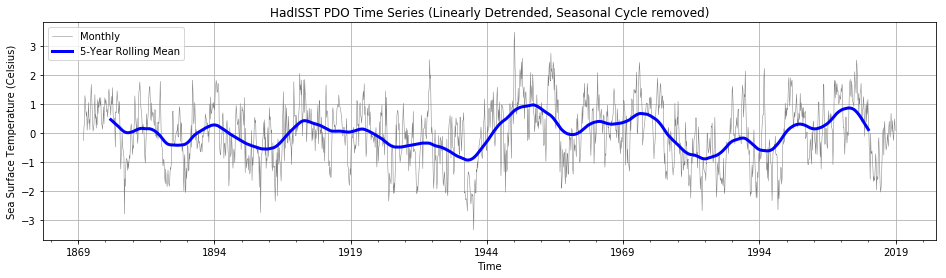

In [118]:
fig = plt.figure(figsize=(16, 4))

ax = fig.add_subplot(111)
hadisst_pdo['pc_norm'].plot(ax=ax,linewidth=.5,color='grey')
hadisst_pdo['pc_norm_smooth'].plot(ax=ax,linewidth=3,color='blue')
ax.set_title('HadISST PDO Time Series (Linearly Detrended, Seasonal Cycle removed)')
ax.set_xlabel('Time')
ax.set_ylabel('Sea Surface Temperature (Celsius)')
ax.legend(['Monthly', '5-Year Rolling Mean'])
ax.grid()

Shown above is the raw (grey) and smooth/filtered (blue) PDO time series over the full record.

In [41]:
cor = np.corrcoef(np.transpose(hadisst_pdo['pc_norm']))
cov = np.cov(np.transpose(hadisst_pdo['pc_norm']))

print('Correlation: ', cor)
print('Covariance:  ', cov)

Correlation:  1.0
Covariance:   1.000559597090094


In [50]:
dTd = np.matmul( np.transpose(hadisst_pdo['pc_norm']), hadisst_pdo['pc_norm'])/(len(hadisst_pdo['pc_norm']))
dTdlag = np.matmul( np.transpose(hadisst_pdo['pc_norm']), roll(hadisst_pdo['pc_norm'],-1,axis=0))/(len(hadisst_pdo['pc_norm']))

print('', dTd)
print('', dTdlag)

In [51]:
#dTdinv = np.linalg.inv(dTd)
M = dTd*dTdlag

prediction = hadisst_pdo['pc_norm']*M
pred_err = hadisst_pdo['pc_norm'] - prediction

In [52]:
prediction

1870-01-01   -0.214777
1870-02-01    0.191914
1870-03-01    0.253142
                ...   
2018-10-01    0.265743
2018-11-01    0.414057
2018-12-01    0.078213
Name: pc_norm, Length: 1788, dtype: float64

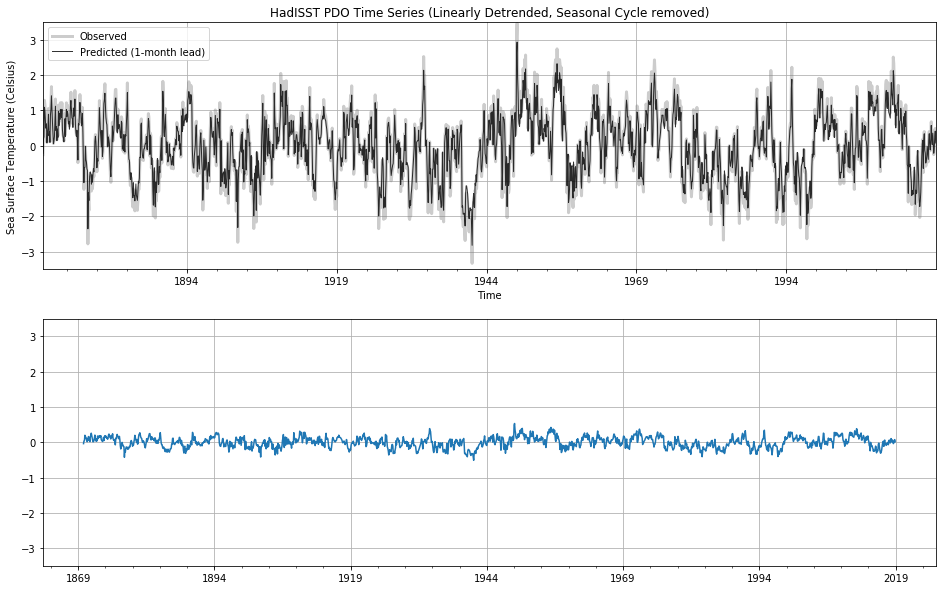

In [87]:
fig = plt.figure(figsize=(16, 10))

ax = fig.add_subplot(211)
hadisst_pdo['pc_norm'].plot(ax=ax,linewidth=3,color='grey', alpha=.4)
prediction.plot(ax=ax,linewidth=1,color='black', alpha=.8)
ax.set_title('HadISST PDO Time Series (Linearly Detrended, Seasonal Cycle removed)')
ax.set_xlabel('Time')
ax.set_ylabel('Sea Surface Temperature (Celsius)')
ax.set_xlim([hadisst_pdo['pc_norm'].index[0],hadisst_pdo['pc_norm'].index[-1]])
ax.set_ylim([-3.5,3.5])
ax.legend(['Observed', 'Predicted (1-month lead)'])
ax.grid()

ax = fig.add_subplot(212)
pred_err.plot(ax=ax)
ax.set_ylim([-3.5,3.5])
ax.grid()

Here, using the ENSO AR1 notebook as a guide, the 1-month prediction at each time step is done. As expected, the prediction is quite close to the observed pattern. The error, or difference between the two, is plotted below the two time series.

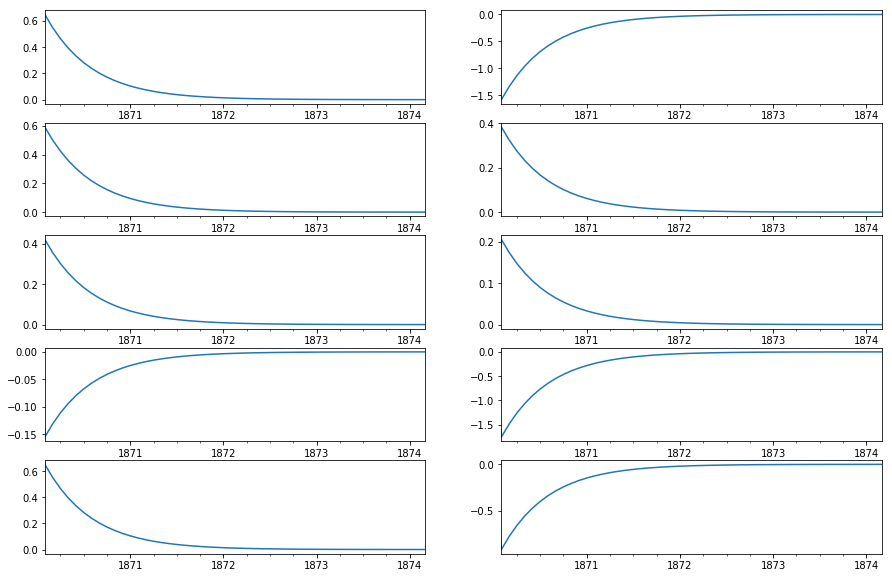

In [117]:
# Optimal (decaying) prediction over time from a random initial state 
fig = plt.figure(figsize=(15,10))

for i in np.arange(10)+1:
    ax = fig.add_subplot(5,2,i)
    pdo_synth = hadisst_pdo['pc_norm']*0 # answer shaped container
    
    # Initial value randomly selected from SSTA data 
    randomtindex = int( np.random.uniform(low=0, high=np.size(hadisst_pdo['pc_norm'])-1) )
    #print(hadisst_pdo['pc_norm'].index[randomtindex], hadisst_pdo['pc_norm'][randomtindex])
    pdo_synth[0] = hadisst_pdo['pc_norm'][randomtindex]
    
    for j in np.arange(size(hadisst_pdo['pc_norm'])-1) + 1: 
        pdo_synth[j] = pdo_synth[j-1]*M
        
    pdo_synth.plot(ax=ax)
    ax.set_xlim(hadisst_pdo['pc_norm'].index[1], hadisst_pdo['pc_norm'].index[50])

A random starting point is chosen 10 times and the AR1 prediction scheme is used. In all of them, exponential decay is apparent, as expected.

However, this is obviously not physical. The next step is to add noise.

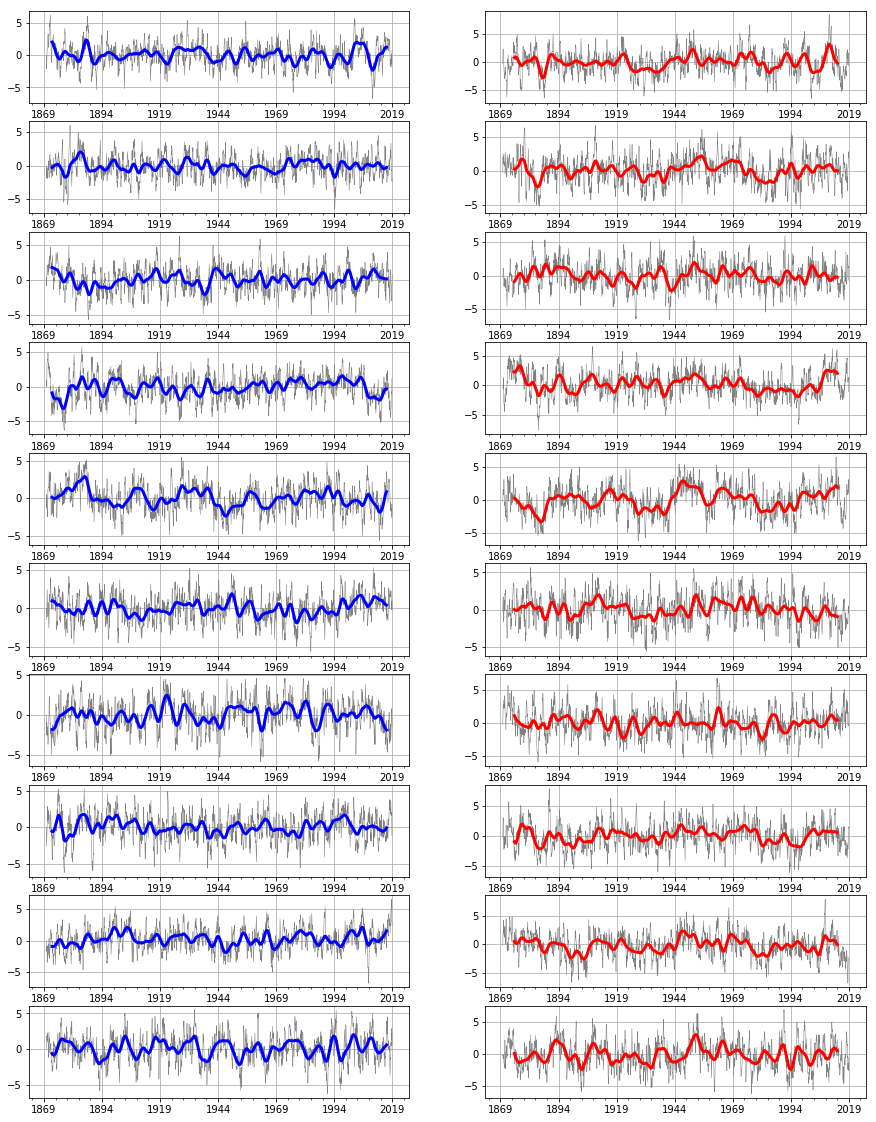

In [119]:
# Optimal (decaying) prediction over time from a random initial state 
fig = plt.figure(figsize=(15,20))

for i in np.arange(10)+1:
    ax = fig.add_subplot(10,2,i*2-1)
    pdo_synth = hadisst_pdo['pc_norm']*0 # answer shaped container
    
    # Initial value randomly selected from SSTA data 
    randomtindex = int( np.random.uniform(low=0, high=np.size(hadisst_pdo['pc_norm'])-1) )
    #print(hadisst_pdo['pc_norm'].index[randomtindex], hadisst_pdo['pc_norm'][randomtindex])
    pdo_synth[0] = hadisst_pdo['pc_norm'][randomtindex]
    
    for j in np.arange(size(hadisst_pdo['pc_norm'])-1) + 1: 
        rand = int( np.random.uniform(low=0, high=np.size(hadisst_pdo['pc_norm'])-1) )
        pdo_synth[j] = pdo_synth[j-1]*M + hadisst_pdo['pc_norm'][rand]
        
    pdo_synth.plot(ax=ax,linewidth=.5,color='grey')
    smooth = pdo_synth.rolling(60,win_type='triang',center=True).mean()
    smooth.plot(ax=ax,linewidth=3,color='blue')
    ax.grid()
    
    ax2 = fig.add_subplot(10,2,i*2)
    (hadisst_pdo['pc_norm'] - pdo_synth).plot(ax=ax2,linewidth=.5,color='grey')
    (hadisst_pdo['pc_norm_smooth'] - smooth).plot(ax=ax2,linewidth=3,color='red')
    ax2.grid()

The prediction method above is repeated here, but this time with random noise added at each timestep. The noise is simply a random value from the observed PDO.

These all show some general PDO-like features, but for the most part end up being relatively meaningless.

I would be interested in trying this with an ensemble approach - taking an ensemble mean, for instance, and using that as the base for an AR1 approach instead of the exponential decay. Essentially, random noise would be added to the ensemble mean and would then be compared to each ensemble member. The goal would be to determine whether an ensemble mean (i.e., the externally forced part of the PDO or any other index) provides any predictability to the index itself.